## Import common libraries

In [1]:
import sqlite3
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

## Load dataset from database table, journal_journalentry

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..","..", "backend"))
DB_PATH = os.path.join(BASE_DIR, "db.sqlite3")

db_dir = os.path.dirname(DB_PATH)
if db_dir and not os.path.exists(db_dir):
    os.makedirs(db_dir, exist_ok=True)

conn = sqlite3.connect(DB_PATH)





In [3]:
# First, let's see what tables exist in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)

# Now query the correct table
df = pd.read_sql_query("SELECT * FROM journal_journalentry;", conn)

df.head()

Available tables: [('django_migrations',), ('sqlite_sequence',), ('auth_group_permissions',), ('auth_user_groups',), ('auth_user_user_permissions',), ('django_admin_log',), ('django_content_type',), ('auth_permission',), ('auth_group',), ('auth_user',), ('django_session',), ('journal_journalentry',)]


,id,text,mood,mood_score,tags,category,created_at,updated_at,user_id
0,1,Today I practiced mindfulness and felt calmer.,happy,8,"[""mindfulness"", ""calm""]",Self-care,2025-09-22 19:46:41.691538,2025-09-22 19:46:41.691571,2
1,2,I felt low today. Missed some important calls ...,sad,3,"[""work"", ""motivation""]",Work,2025-09-22 21:56:26.714902,2025-09-22 21:56:26.714953,2
2,3,"I was worried about the upcoming presentation,...",anxious,4,"[""presentation"", ""stress""]",Career,2025-09-22 21:56:56.809605,2025-09-22 21:56:56.809652,2
3,4,Today was a great day! I went jogging and felt...,happy,9,"[""exercise"", ""wellness"", ""outdoors""]",Health,2025-09-22 22:00:23.950201,2025-09-22 22:00:23.950231,3
4,5,"A normal day, went through routine tasks witho...",neutral,6,"[""routine"", ""daily""]",Personal,2025-09-22 22:01:43.580868,2025-09-22 22:01:43.580912,3


## Inspect the dataset

In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          10 non-null     int64 
 1   text        10 non-null     object
 2   mood        10 non-null     object
 3   mood_score  10 non-null     int64 
 4   tags        10 non-null     object
 5   category    10 non-null     object
 6   created_at  10 non-null     object
 7   updated_at  10 non-null     object
 8   user_id     10 non-null     int64 
dtypes: int64(3), object(6)
memory usage: 852.0+ bytes


,id,mood_score,user_id
count,10.000000,10.000000,10.000000
mean,6.300000,5.900000,3.100000
std,3.945462,1.969207,0.875595
min,1.000000,3.000000,2.000000
25%,3.250000,4.250000,2.250000
50%,5.500000,6.000000,3.000000
75%,9.750000,7.500000,4.000000
max,12.000000,9.000000,4.000000


## Data Cleaning 

### Check for missing values

In [5]:
df.isna().sum()

id            0
text          0
mood          0
mood_score    0
tags          0
category      0
created_at    0
updated_at    0
user_id       0
dtype: int64

### Check for duplicates

In [6]:
print("\n🧭 Duplicate Rows:", df.duplicated().sum())


🧭 Duplicate Rows: 0


### Drop Unnecessary Columns

In [7]:
df = df.drop(columns=["id", "user_id","updated_at"])
df.head()

,text,mood,mood_score,tags,category,created_at
0,Today I practiced mindfulness and felt calmer.,happy,8,"[""mindfulness"", ""calm""]",Self-care,2025-09-22 19:46:41.691538
1,I felt low today. Missed some important calls ...,sad,3,"[""work"", ""motivation""]",Work,2025-09-22 21:56:26.714902
2,"I was worried about the upcoming presentation,...",anxious,4,"[""presentation"", ""stress""]",Career,2025-09-22 21:56:56.809605
3,Today was a great day! I went jogging and felt...,happy,9,"[""exercise"", ""wellness"", ""outdoors""]",Health,2025-09-22 22:00:23.950201
4,"A normal day, went through routine tasks witho...",neutral,6,"[""routine"", ""daily""]",Personal,2025-09-22 22:01:43.580868


### Drop empty or invalid entries

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)             # remove @mentions
    text = re.sub(r"[^a-zA-Z\s]", " ", text)     # remove punctuation, numbers
    text = re.sub(r"\s+", " ", text).strip()     # collapse spaces
    return text

In [9]:
# Save cleaned dataset

# Get base directory relative to notebook
base_dir = Path().resolve().parent  # since notebook is inside /notebooks/

# Construct full save path
clean_path = base_dir / "data" / "cleaned" / "mental_health_journal_cleaned.csv"

# Save file
df.to_csv(clean_path, index=False)
print(f"✅ Saved cleaned dataset to: {clean_path}")

✅ Saved cleaned dataset to: D:\project Github\web dev + machine learning\mental-health-journal\machine-learning\data\cleaned\mental_health_journal_cleaned.csv


## Exploratory Data Analysis

### Text Length Distributions

In [10]:
df["char_length"] = df["text"].astype(str).apply(len)
df["word_length"] = df["text"].astype(str).apply(lambda x: len(x.split()))

#### Character Length

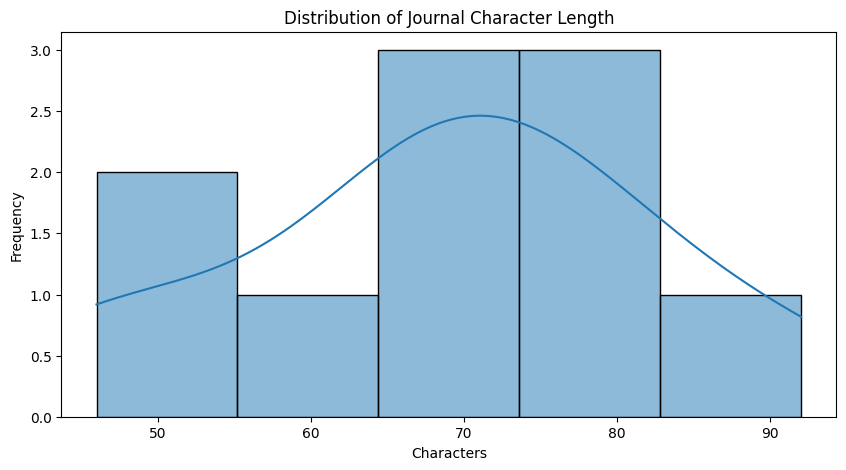

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(df['char_length'], kde=True)
plt.title("Distribution of Journal Character Length")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

#### Word Length

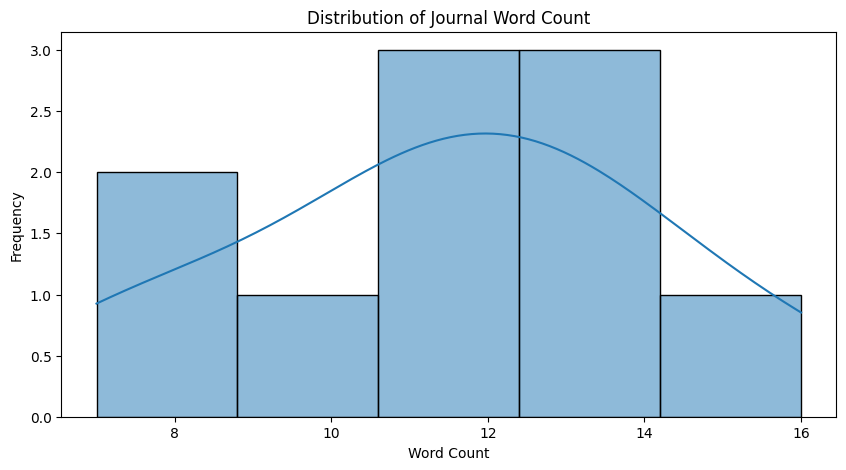

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(df['word_length'], kde=True)
plt.title("Distribution of Journal Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Journal Entries Over Time

In [13]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date

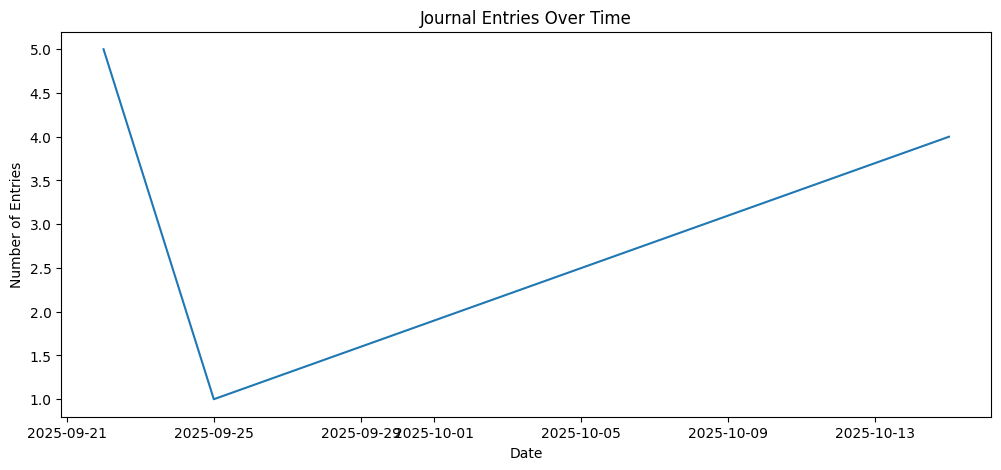

In [14]:
plt.figure(figsize=(12,5))
df['date'].value_counts().sort_index().plot()
plt.title("Journal Entries Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.show()

### Word Frequency Analysis

In [15]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [16]:
df["tokens"] = df["text"].astype(str).apply(clean_text)

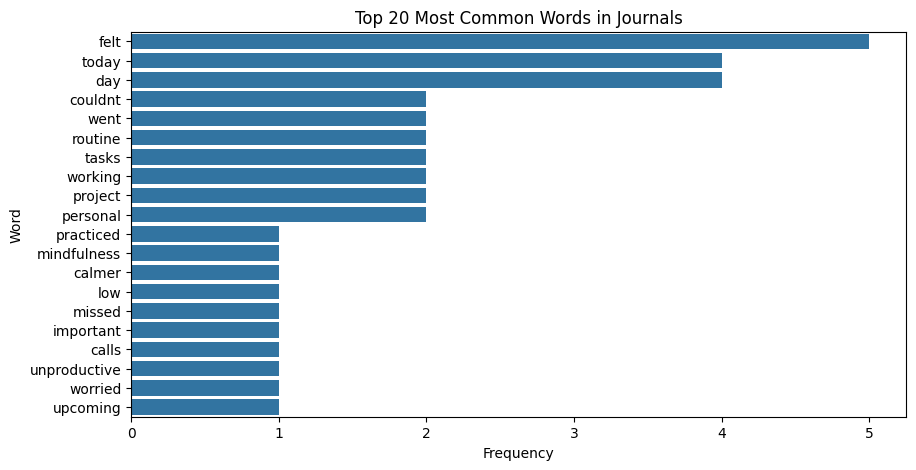

In [17]:
all_words = df["tokens"].explode()
word_freq = Counter(all_words).most_common(20)

words, counts = zip(*word_freq)

plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words in Journals")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


### Word Cloud

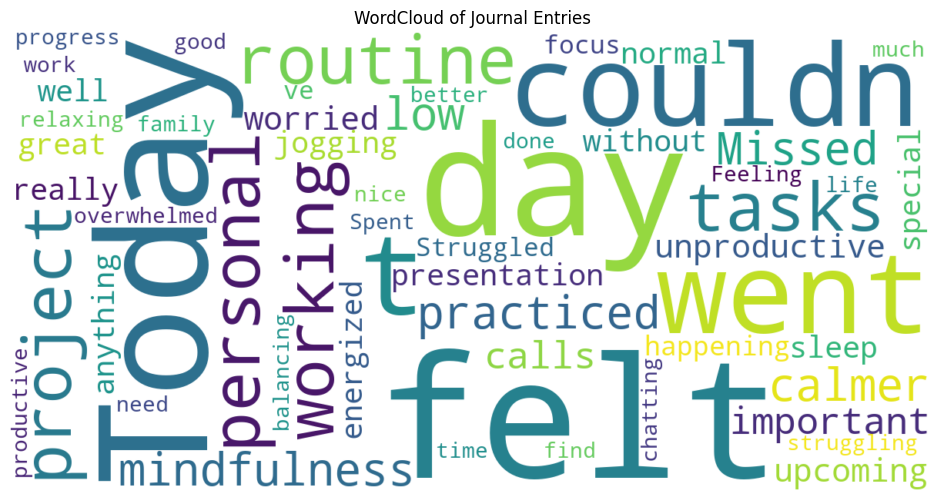

In [18]:
text_blob = " ".join(df['text'].astype(str))

wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(text_blob)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Journal Entries")
plt.show()


### Bigram / Trigram Analysis

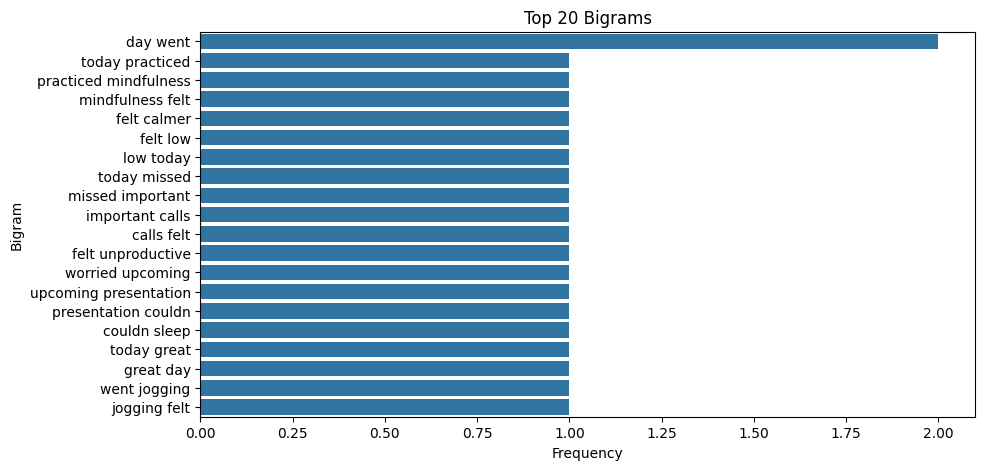

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
bigrams = vectorizer.fit_transform(df["text"].astype(str))
sum_bigrams = bigrams.sum(axis=0)
bigram_freq = [(word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:20]

bigram_words, bigram_counts = zip(*bigram_freq)

plt.figure(figsize=(10,5))
sns.barplot(x=list(bigram_counts), y=list(bigram_words))
plt.title("Top 20 Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()
